# Analyzing All Invariant Mass Array Sizes

This notebook analyzes ALL invariant mass arrays in the output directory to:
1. Find arrays with similar file sizes
2. Determine why similar sizes occur
3. Check if arrays with similar sizes contain the same data
4. Group arrays by file, final state, and combination patterns


In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline
plt.style.use('default')


In [2]:
# Configuration
output_dir = "/storage/agrp/netalev/data/inv_masses/"

# Find all .npy files
all_files = [f for f in os.listdir(output_dir) if f.endswith('.npy')]
print(f"Found {len(all_files)} invariant mass array files")

# Parse filenames to extract metadata
# Format: {base_filename}_FS_{final_state}_IM_{e}e_{j}j_{m}m_{p}p.npy
import re

def parse_filename(filename):
    """Parse IM array filename to extract components."""
    # Remove .npy extension
    base = filename.replace('.npy', '')
    
    # Split by _FS_ and _IM_ markers to handle underscores in filenames
    # Pattern: ..._FS_{final_state}_IM_{combination}
    # We need to find the last occurrence of _FS_ and _IM_ to handle cases where
    # base_filename might contain _FS_ or _IM_ (unlikely but possible)
    
    # Find _FS_ marker
    fs_idx = base.rfind('_FS_')
    if fs_idx == -1:
        return None
    
    # Find _IM_ marker after _FS_
    im_idx = base.find('_IM_', fs_idx)
    if im_idx == -1:
        return None
    
    # Extract components
    base_filename = base[:fs_idx]
    final_state = base[fs_idx + 4:im_idx]  # +4 to skip '_FS_'
    combination_str = base[im_idx + 4:]  # +4 to skip '_IM_'
    
    # Parse combination: Try new format first (Ne_Nj_Nm_Np - always 4 parts)
    combo_pattern_new = r'^(\d+)e_(\d+)j_(\d+)m_(\d+)p$'
    combo_match = re.match(combo_pattern_new, combination_str)
    
    if combo_match:
        # New format: always has all 4 particle types
        combination = {
            'Electrons': int(combo_match.group(1)),
            'Jets': int(combo_match.group(2)),
            'Muons': int(combo_match.group(3)),
            'Photons': int(combo_match.group(4))
        }
        return {
            'filename': filename,
            'base_filename': base_filename,
            'final_state': final_state,
            'combination': combination,
            'combination_str': combination_str
        }
    
    # Try old format (variable number of particles, e.g., "2e_1j_2p" or "1j_2m")
    # This handles legacy files that might not have all 4 particle types
    combo_parts = combination_str.split('_')
    combination = {'Electrons': 0, 'Jets': 0, 'Muons': 0, 'Photons': 0}
    
    for part in combo_parts:
        # Match pattern like "2e", "1j", "3m", "2p"
        part_match = re.match(r'^(\d+)([ejmp])$', part)
        if part_match:
            count = int(part_match.group(1))
            particle_code = part_match.group(2)
            if particle_code == 'e':
                combination['Electrons'] = count
            elif particle_code == 'j':
                combination['Jets'] = count
            elif particle_code == 'm':
                combination['Muons'] = count
            elif particle_code == 'p':
                combination['Photons'] = count
    
    # Check if we parsed at least one particle
    if sum(combination.values()) > 0:
        return {
            'filename': filename,
            'base_filename': base_filename,
            'final_state': final_state,
            'combination': combination,
            'combination_str': combination_str
        }
    
    return None

# Parse all files
parsed_files = []
failed_files = []
for f in all_files:
    parsed = parse_filename(f)
    if parsed:
        parsed_files.append(parsed)
    else:
        failed_files.append(f)

print(f"\nSuccessfully parsed {len(parsed_files)} files")
if failed_files:
    print(f"Failed to parse {len(failed_files)} files:")
    for f in failed_files[:10]:  # Show first 10
        print(f"  - {f}")
    if len(failed_files) > 10:
        print(f"  ... and {len(failed_files) - 10} more")


Found 183 invariant mass array files

Successfully parsed 183 files


In [3]:
# Load file sizes and array properties
file_data = []

for parsed in parsed_files:
    filepath = os.path.join(output_dir, parsed['filename'])
    if os.path.exists(filepath):
        file_size = os.path.getsize(filepath)
        
        # Load array to get properties
        try:
            arr = np.load(filepath)
            file_data.append({
                **parsed,
                'file_size': file_size,
                'array_size': arr.size,
                'array_shape': arr.shape,
                'dtype': str(arr.dtype),
                'nbytes': arr.nbytes,
                'min': float(np.min(arr)) if arr.size > 0 else None,
                'max': float(np.max(arr)) if arr.size > 0 else None,
                'mean': float(np.mean(arr)) if arr.size > 0 else None,
                'std': float(np.std(arr)) if arr.size > 0 else None,
            })
        except Exception as e:
            print(f"Error loading {parsed['filename']}: {e}")

df = pd.DataFrame(file_data)
print(f"Loaded {len(df)} arrays")
print(f"\nFile size statistics:")
print(df['file_size'].describe())
print(f"\nArray size statistics:")
print(df['array_size'].describe())


Loaded 183 arrays

File size statistics:
count    1.830000e+02
mean     7.987504e+05
std      1.956567e+06
min      4.160000e+02
25%      3.584000e+03
50%      2.993600e+04
75%      3.089000e+05
max      9.446672e+06
Name: file_size, dtype: float64

Array size statistics:
count    1.830000e+02
mean     9.982780e+04
std      2.445709e+05
min      3.600000e+01
25%      4.320000e+02
50%      3.726000e+03
75%      3.859650e+04
max      1.180818e+06
Name: array_size, dtype: float64


In [4]:
# Find arrays with similar file sizes
# Group by file size (within 1KB tolerance)
df['file_size_rounded'] = (df['file_size'] / 1024).round().astype(int)

size_groups = df.groupby('file_size_rounded')
similar_sized_groups = size_groups.filter(lambda x: len(x) > 1)

print(f"Found {len(similar_sized_groups)} arrays in groups with similar sizes")
print(f"Number of size groups: {len(size_groups)}")
print(f"Number of groups with multiple arrays: {len([g for name, g in size_groups if len(g) > 1])}")

# Show groups with multiple arrays
print("\n=== Groups of arrays with similar file sizes ===")
for size_kb, group in size_groups:
    if len(group) > 1:
        print(f"\nSize group: ~{size_kb} KB ({len(group)} arrays)")
        for idx, row in group.iterrows():
            print(f"  - {row['filename']}")
            print(f"    Array size: {row['array_size']:,} elements, "
                  f"FS: {row['final_state']}, IM: {row['combination_str']}")


Found 178 arrays in groups with similar sizes
Number of size groups: 36
Number of groups with multiple arrays: 31

=== Groups of arrays with similar file sizes ===

Size group: ~1 KB (21 arrays)
  - 2025e-13tev-beta_mc_621dee36677d45ec_FS_1e_1m_3j_3p_IM_1e_3j_3p.npy
    Array size: 54 elements, FS: 1e_1m_3j_3p, IM: 1e_3j_3p
  - 2025e-13tev-beta_9a23453bcbc27b19_FS_2e_2m_2j_3p_IM_2j_3p.npy
    Array size: 54 elements, FS: 2e_2m_2j_3p, IM: 2j_3p
  - 2025e-13tev-beta_mc_21c3213e02bc3f7b_FS_1e_1m_4j_3p_IM_1e_4j_1m_3p.npy
    Array size: 54 elements, FS: 1e_1m_4j_3p, IM: 1e_4j_1m_3p
  - 2025e-13tev-beta_9a23453bcbc27b19_FS_2e_2m_2j_3p_IM_2j_2m_3p.npy
    Array size: 108 elements, FS: 2e_2m_2j_3p, IM: 2j_2m_3p
  - 2025e-13tev-beta_mc_21c3213e02bc3f7b_FS_1e_1m_3j_3p_IM_1e_3j_1m_3p.npy
    Array size: 108 elements, FS: 1e_1m_3j_3p, IM: 1e_3j_1m_3p
  - 2025e-13tev-beta_9a23453bcbc27b19_FS_1e_1m_1j_3p_IM_1j.npy
    Array size: 162 elements, FS: 1e_1m_1j_3p, IM: 1j
  - 2025e-13tev-beta_9a23453bcb

In [5]:
# Compare arrays within each size group
print("=== Comparing arrays with similar sizes ===\n")

comparison_results = []

for size_kb, group in size_groups:
    if len(group) > 1:
        # Compare all pairs in this group
        group_list = group.to_dict('records')
        
        for i in range(len(group_list)):
            for j in range(i + 1, len(group_list)):
                arr1_info = group_list[i]
                arr2_info = group_list[j]
                
                # Load arrays
                arr1_path = os.path.join(output_dir, arr1_info['filename'])
                arr2_path = os.path.join(output_dir, arr2_info['filename'])
                
                try:
                    arr1 = np.load(arr1_path)
                    arr2 = np.load(arr2_path)
                    
                    # Compare
                    same_size = arr1.size == arr2.size
                    same_shape = arr1.shape == arr2.shape
                    same_dtype = arr1.dtype == arr2.dtype
                    
                    are_identical = False
                    max_diff = None
                    mean_diff = None
                    pct_different = None
                    
                    if same_shape:
                        are_identical = np.array_equal(arr1, arr2)
                        if not are_identical:
                            diff = arr1 - arr2
                            max_diff = float(np.max(np.abs(diff)))
                            mean_diff = float(np.mean(np.abs(diff)))
                            pct_different = 100 * np.sum(arr1 != arr2) / arr1.size
                    
                    # Normalize combination strings for comparison (remove any whitespace)
                    combo1_norm = arr1_info['combination_str'].strip()
                    combo2_norm = arr2_info['combination_str'].strip()
                    same_combo = combo1_norm == combo2_norm
                    
                    comparison_results.append({
                        'file1': arr1_info['filename'],
                        'file2': arr2_info['filename'],
                        'fs1': arr1_info['final_state'],
                        'fs2': arr2_info['final_state'],
                        'combo1': combo1_norm,
                        'combo2': combo2_norm,
                        'same_fs': arr1_info['final_state'] == arr2_info['final_state'],
                        'same_base': arr1_info['base_filename'] == arr2_info['base_filename'],
                        'same_combo': same_combo,
                        'same_size': same_size,
                        'same_shape': same_shape,
                        'same_dtype': same_dtype,
                        'identical': are_identical,
                        'max_diff': max_diff,
                        'mean_diff': mean_diff,
                        'pct_different': pct_different,
                        'arr1_size': arr1.size,
                        'arr2_size': arr2.size,
                    })
                    
                except Exception as e:
                    print(f"Error comparing {arr1_info['filename']} and {arr2_info['filename']}: {e}")

comparison_df = pd.DataFrame(comparison_results)
if len(comparison_df) > 0:
    print(f"Made {len(comparison_df)} pairwise comparisons")
    print("\n=== Summary ===")
    print(f"Same file size: {comparison_df['same_size'].sum()} / {len(comparison_df)}")
    print(f"Identical arrays: {comparison_df['identical'].sum()} / {len(comparison_df)}")
    print(f"Same final state: {comparison_df['same_fs'].sum()} / {len(comparison_df)}")
    print(f"Same base file: {comparison_df['same_base'].sum()} / {len(comparison_df)}")
    
    # Show identical arrays - separate into same combo vs different combo
    identical = comparison_df[comparison_df['identical'] == True]
    if len(identical) > 0:
        # Separate: same combination vs different combination
        identical_same_combo = identical[identical['same_combo'] == True]
        identical_diff_combo = identical[identical['same_combo'] == False]
        
        if len(identical_same_combo) > 0:
            print(f"\n⚠️  Found {len(identical_same_combo)} pairs of IDENTICAL arrays with SAME combinations:")
            print("   (These might be duplicate files or same calculation saved twice)")
            print(identical_same_combo[['file1', 'file2', 'combo1', 'combo2', 'same_base', 'same_fs']].to_string())
        
        if len(identical_diff_combo) > 0:
            print(f"\n⚠️  WARNING: Found {len(identical_diff_combo)} pairs of IDENTICAL arrays with DIFFERENT combinations!")
            print("   (This is a BUG - different combinations should produce different results)")
            print(identical_diff_combo[['file1', 'file2', 'combo1', 'combo2', 'same_base', 'same_fs']].to_string())


=== Comparing arrays with similar sizes ===

Made 771 pairwise comparisons

=== Summary ===
Same file size: 573 / 771
Identical arrays: 12 / 771
Same final state: 484 / 771
Same base file: 286 / 771

⚠️  Found 12 pairs of IDENTICAL arrays with SAME combinations:
   (These might be duplicate files or same calculation saved twice)
                                                                      file1                                                                   file2       combo1       combo2  same_base  same_fs
12      2025e-13tev-beta_mc_621dee36677d45ec_FS_1e_1m_3j_3p_IM_1e_3j_3p.npy     2025e-13tev-beta_mc_21c3213e02bc3f7b_FS_1e_1m_3j_3p_IM_1e_3j_3p.npy     1e_3j_3p     1e_3j_3p      False     True
48   2025e-13tev-beta_mc_21c3213e02bc3f7b_FS_1e_1m_4j_3p_IM_1e_4j_1m_3p.npy  2025e-13tev-beta_mc_621dee36677d45ec_FS_1e_1m_4j_3p_IM_1e_4j_1m_3p.npy  1e_4j_1m_3p  1e_4j_1m_3p      False     True
86   2025e-13tev-beta_mc_21c3213e02bc3f7b_FS_1e_1m_3j_3p_IM_1e_3j_1m_3p.npy  2025e-13te

In [6]:
# Display identical arrays side by side for detailed comparison
if len(comparison_df) > 0:
    identical = comparison_df[comparison_df['identical'] == True]
    
    if len(identical) > 0:
        print("=" * 80)
        print(f"DETAILED SIDE-BY-SIDE COMPARISON OF {len(identical)} IDENTICAL ARRAY PAIRS")
        print("=" * 80)
        
        for idx, row in identical.iterrows():
            print(f"\n{'='*80}")
            print(f"Pair {idx + 1}/{len(identical)}")
            print(f"{'='*80}")
            
            # Load both arrays
            arr1_path = os.path.join(output_dir, row['file1'])
            arr2_path = os.path.join(output_dir, row['file2'])
            
            arr1 = np.load(arr1_path)
            arr2 = np.load(arr2_path)
            
            # Create comparison table
            comparison_data = {
                'Property': [
                    'Filename',
                    'Base File',
                    'Final State',
                    'Combination',
                    'Array Size',
                    'File Size (KB)',
                    'Min (GeV)',
                    'Max (GeV)',
                    'Mean (GeV)',
                    'Median (GeV)',
                    'Std (GeV)',
                    'First 10 Values'
                ],
                'Array 1': [
                    row['file1'],
                    row['file1'].split('_FS_')[0],
                    row['fs1'],
                    row['combo1'],
                    f"{len(arr1):,}",
                    f"{os.path.getsize(arr1_path) / 1024:.2f}",
                    f"{np.min(arr1):.6f}",
                    f"{np.max(arr1):.6f}",
                    f"{np.mean(arr1):.6f}",
                    f"{np.median(arr1):.6f}",
                    f"{np.std(arr1):.6f}",
                    str(arr1[:10].tolist() if len(arr1) >= 10 else arr1.tolist())
                ],
                'Array 2': [
                    row['file2'],
                    row['file2'].split('_FS_')[0],
                    row['fs2'],
                    row['combo2'],
                    f"{len(arr2):,}",
                    f"{os.path.getsize(arr2_path) / 1024:.2f}",
                    f"{np.min(arr2):.6f}",
                    f"{np.max(arr2):.6f}",
                    f"{np.mean(arr2):.6f}",
                    f"{np.median(arr2):.6f}",
                    f"{np.std(arr2):.6f}",
                    str(arr2[:10].tolist() if len(arr2) >= 10 else arr2.tolist())
                ],
                'Match': [
                    '❌' if row['file1'] != row['file2'] else '✓',
                    '❌' if row['file1'].split('_FS_')[0] != row['file2'].split('_FS_')[0] else '✓',
                    '❌' if row['fs1'] != row['fs2'] else '✓',
                    '❌' if row['combo1'] != row['combo2'] else '✓',
                    '✓' if len(arr1) == len(arr2) else '❌',
                    '✓' if abs(os.path.getsize(arr1_path) - os.path.getsize(arr2_path)) < 100 else '❌',
                    '✓' if np.isclose(np.min(arr1), np.min(arr2)) else '❌',
                    '✓' if np.isclose(np.max(arr1), np.max(arr2)) else '❌',
                    '✓' if np.isclose(np.mean(arr1), np.mean(arr2)) else '❌',
                    '✓' if np.isclose(np.median(arr1), np.median(arr2)) else '❌',
                    '✓' if np.isclose(np.std(arr1), np.std(arr2)) else '❌',
                    '✓ IDENTICAL' if np.array_equal(arr1[:10] if len(arr1) >= 10 else arr1, 
                                                    arr2[:10] if len(arr2) >= 10 else arr2) else '❌'
                ]
            }
            
            comp_df = pd.DataFrame(comparison_data)
            print(comp_df.to_string(index=False))
            
            # Verify they're truly identical
            are_identical = np.array_equal(arr1, arr2)
            print(f"\n✓ Verified: Arrays are {'IDENTICAL' if are_identical else 'DIFFERENT'}")
            
            # Check if combinations are actually different
            combo1_norm = str(row['combo1']).strip()
            combo2_norm = str(row['combo2']).strip()
            are_different_combos = combo1_norm != combo2_norm
            
            if are_identical:
                if are_different_combos:
                    print(f"⚠️  WARNING: Different combinations ({combo1_norm} vs {combo2_norm}) produce IDENTICAL results!")
                    print(f"   This is a BUG - different combinations should produce different invariant masses!")
                else:
                    print(f"ℹ️  INFO: Same combinations ({combo1_norm}) - arrays are identical (expected if same file/calculation)")
                    print(f"   Checking if these are duplicate files...")
                    if row['file1'] == row['file2']:
                        print(f"   ⚠️  Same filename - this is a duplicate file!")
                    elif row['file1'].split('_FS_')[0] == row['file2'].split('_FS_')[0]:
                        print(f"   ⚠️  Same base file - might be duplicate calculations saved twice")
            
            # Show a sample of values side by side
            num_samples = min(20, len(arr1), len(arr2))
            print(f"\nFirst {num_samples} values side by side:")
            print(f"{'Index':<8} {'Array 1':<15} {'Array 2':<15} {'Match':<8}")
            print("-" * 50)
            for i in range(num_samples):
                val1 = arr1[i]
                val2 = arr2[i]
                match = '✓' if np.isclose(val1, val2) or val1 == val2 else '❌'
                print(f"{i:<8} {val1:<15.6f} {val2:<15.6f} {match:<8}")
            
            if len(arr1) > num_samples:
                print(f"... (showing first {num_samples} of {len(arr1):,} values)")
        
        print(f"\n{'='*80}")
        print(f"SUMMARY: Found {len(identical)} pairs of IDENTICAL arrays")
        print(f"{'='*80}")
    else:
        print("\n✓ No identical arrays found - all combinations produce different results!")


DETAILED SIDE-BY-SIDE COMPARISON OF 12 IDENTICAL ARRAY PAIRS

Pair 13/12
       Property                                                                                                                                                                                                  Array 1                                                                                                                                                                                                  Array 2       Match
       Filename                                                                                                                                      2025e-13tev-beta_mc_621dee36677d45ec_FS_1e_1m_3j_3p_IM_1e_3j_3p.npy                                                                                                                                      2025e-13tev-beta_mc_21c3213e02bc3f7b_FS_1e_1m_3j_3p_IM_1e_3j_3p.npy           ❌
      Base File                                                    

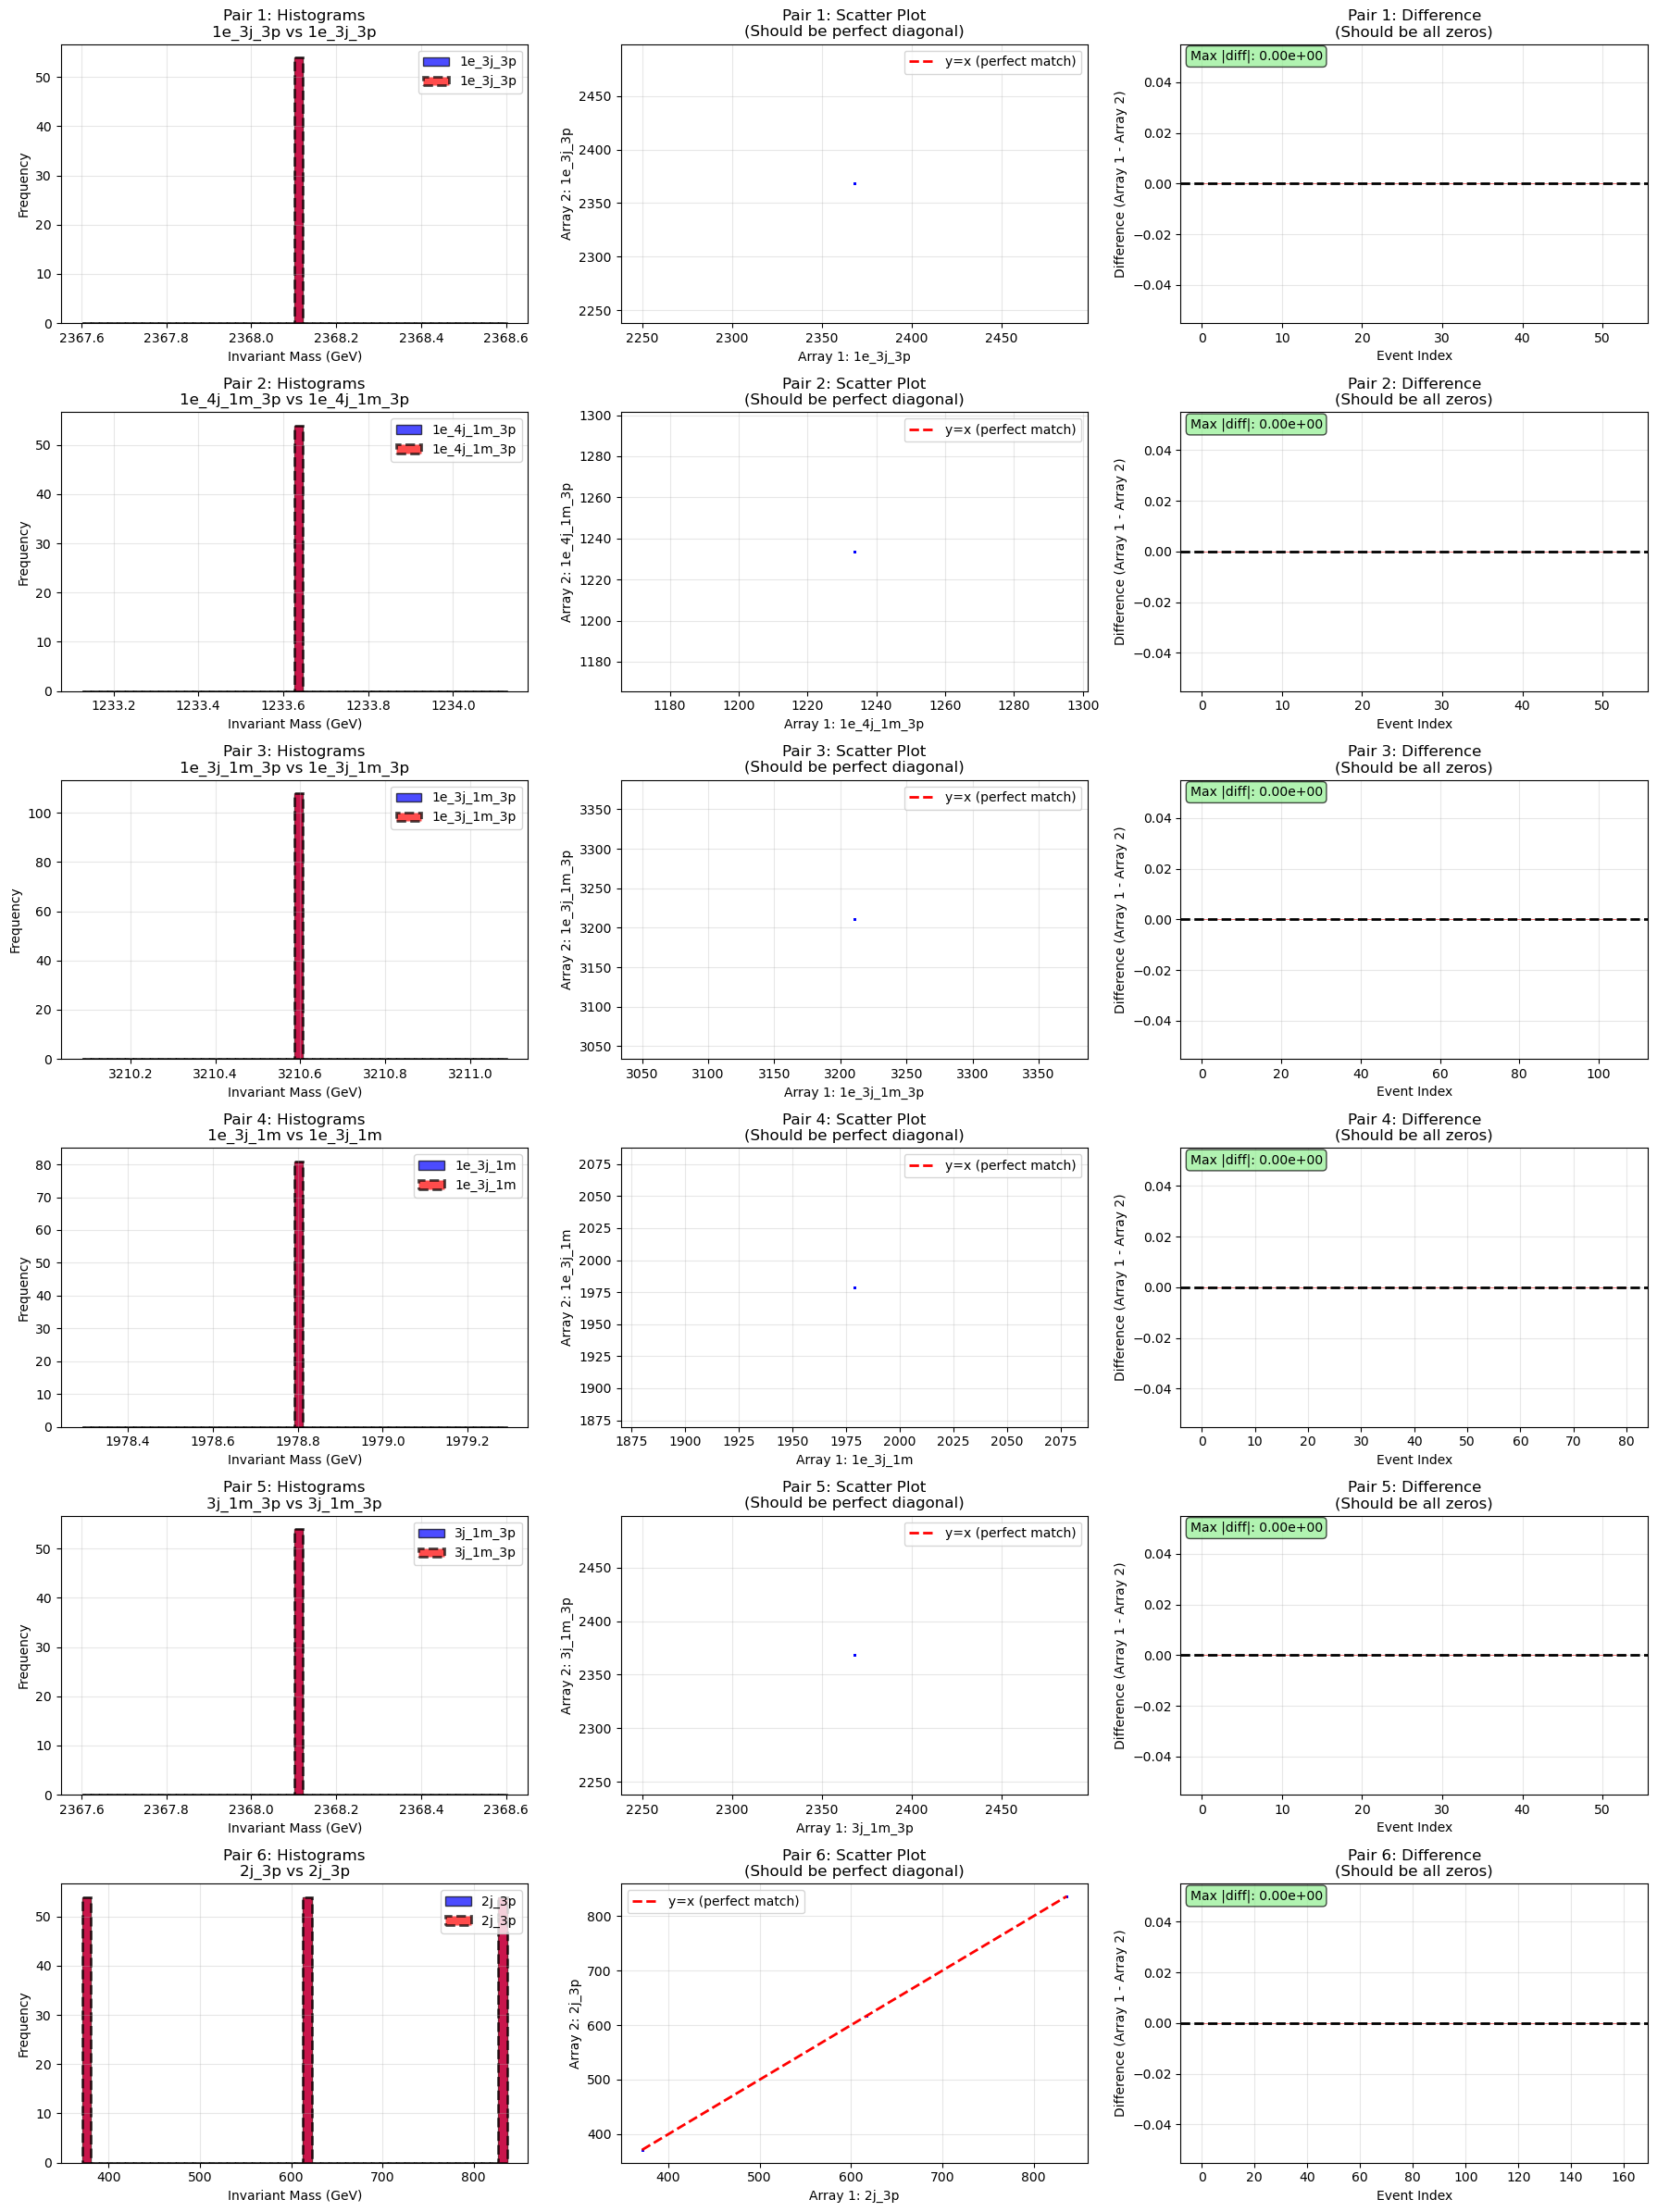


Visualized 6 of 12 identical array pairs
ℹ️  12 pairs have SAME combinations (might be duplicates)
(Showing first 6 pairs - total: 12 pairs)


In [7]:
# Visualize identical arrays side by side
# Focus on those with DIFFERENT combinations (the real bugs)
if len(comparison_df) > 0:
    identical = comparison_df[comparison_df['identical'] == True]
    
    # Prioritize showing arrays with different combinations (the actual bugs)
    identical_diff_combo = identical[identical['same_combo'] == False]
    identical_same_combo = identical[identical['same_combo'] == True]
    
    # Show different combo pairs first, then same combo pairs
    identical_to_plot = pd.concat([identical_diff_combo, identical_same_combo]).reset_index(drop=True)
    
    if len(identical_to_plot) > 0:
        # Limit to first 6 pairs for visualization (to avoid too many plots)
        num_pairs_to_plot = min(6, len(identical_to_plot))
        
        fig, axes = plt.subplots(num_pairs_to_plot, 3, figsize=(18, 4 * num_pairs_to_plot))
        if num_pairs_to_plot == 1:
            axes = axes.reshape(1, -1)
        
        for plot_idx in range(num_pairs_to_plot):
            row = identical_to_plot.iloc[plot_idx]
            
            # Add warning indicator if different combinations
            is_bug = not row['same_combo']
            bug_label = " [BUG!]" if is_bug else " [Same Combo]"
            
            # Load arrays
            arr1_path = os.path.join(output_dir, row['file1'])
            arr2_path = os.path.join(output_dir, row['file2'])
            
            arr1 = np.load(arr1_path)
            arr2 = np.load(arr2_path)
            
            # Histogram comparison
            axes[plot_idx, 0].hist(arr1, bins=50, alpha=0.7, label=f"{row['combo1']}", 
                                  color='blue', edgecolor='black')
            axes[plot_idx, 0].hist(arr2, bins=50, alpha=0.7, label=f"{row['combo2']}", 
                                  color='red', edgecolor='black', linestyle='--', linewidth=2)
            axes[plot_idx, 0].set_xlabel('Invariant Mass (GeV)')
            axes[plot_idx, 0].set_ylabel('Frequency')
            title_suffix = bug_label if is_bug else ""
            axes[plot_idx, 0].set_title(f'Pair {plot_idx+1}: Histograms{title_suffix}\n{row["combo1"]} vs {row["combo2"]}')
            axes[plot_idx, 0].legend()
            axes[plot_idx, 0].grid(True, alpha=0.3)
            
            # Scatter plot (should be perfect diagonal if identical)
            axes[plot_idx, 1].scatter(arr1, arr2, alpha=0.3, s=1, color='blue')
            min_val = min(arr1.min(), arr2.min())
            max_val = max(arr1.max(), arr2.max())
            axes[plot_idx, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='y=x (perfect match)')
            axes[plot_idx, 1].set_xlabel(f'Array 1: {row["combo1"]}')
            axes[plot_idx, 1].set_ylabel(f'Array 2: {row["combo2"]}')
            axes[plot_idx, 1].set_title(f'Pair {plot_idx+1}: Scatter Plot{title_suffix}\n(Should be perfect diagonal)')
            axes[plot_idx, 1].legend()
            axes[plot_idx, 1].grid(True, alpha=0.3)
            
            # Difference plot (should be all zeros if identical)
            diff = arr1 - arr2
            axes[plot_idx, 2].plot(diff, alpha=0.7, color='red', linewidth=0.5)
            axes[plot_idx, 2].axhline(y=0, color='black', linestyle='--', linewidth=2)
            axes[plot_idx, 2].set_xlabel('Event Index')
            axes[plot_idx, 2].set_ylabel('Difference (Array 1 - Array 2)')
            axes[plot_idx, 2].set_title(f'Pair {plot_idx+1}: Difference{title_suffix}\n(Should be all zeros)')
            axes[plot_idx, 2].grid(True, alpha=0.3)
            
            # Add text annotation
            max_diff = np.max(np.abs(diff))
            axes[plot_idx, 2].text(0.02, 0.98, f'Max |diff|: {max_diff:.2e}', 
                                  transform=axes[plot_idx, 2].transAxes,
                                  verticalalignment='top', bbox=dict(boxstyle='round', 
                                  facecolor='yellow' if max_diff > 1e-10 else 'lightgreen', alpha=0.7))
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nVisualized {num_pairs_to_plot} of {len(identical_to_plot)} identical array pairs")
        if len(identical_diff_combo) > 0:
            print(f"⚠️  {len(identical_diff_combo)} pairs have DIFFERENT combinations (BUGS!)")
        if len(identical_same_combo) > 0:
            print(f"ℹ️  {len(identical_same_combo)} pairs have SAME combinations (might be duplicates)")
        if len(identical_to_plot) > num_pairs_to_plot:
            print(f"(Showing first {num_pairs_to_plot} pairs - total: {len(identical_to_plot)} pairs)")


In [8]:
# Additional debugging: Check for actual calculation bugs
# Compare a few specific values to see if there are numerical issues
if len(comparison_df) > 0:
    identical = comparison_df[comparison_df['identical'] == True]
    identical_diff_combo = identical[identical['same_combo'] == False]
    
    if len(identical_diff_combo) > 0:
        print("=" * 80)
        print("DETAILED ANALYSIS OF BUGS: Identical arrays with different combinations")
        print("=" * 80)
        
        for idx, row in identical_diff_combo.iterrows():
            print(f"\n{'='*80}")
            print(f"BUG #{idx + 1}: {row['combo1']} vs {row['combo2']}")
            print(f"{'='*80}")
            
            arr1_path = os.path.join(output_dir, row['file1'])
            arr2_path = os.path.join(output_dir, row['file2'])
            
            arr1 = np.load(arr1_path)
            arr2 = np.load(arr2_path)
            
            print(f"File 1: {row['file1']}")
            print(f"File 2: {row['file2']}")
            print(f"Base file 1: {row['file1'].split('_FS_')[0]}")
            print(f"Base file 2: {row['file2'].split('_FS_')[0]}")
            print(f"Same base file: {row['same_base']}")
            print(f"Final state 1: {row['fs1']}")
            print(f"Final state 2: {row['fs2']}")
            print(f"Same final state: {row['same_fs']}")
            print(f"\nCombination 1: {row['combo1']}")
            print(f"Combination 2: {row['combo2']}")
            
            # Parse combinations to see what's different
            def parse_combo(combo_str):
                """Parse combination string into dict."""
                parts = combo_str.split('_')
                combo_dict = {'e': 0, 'j': 0, 'm': 0, 'p': 0}
                for part in parts:
                    match = re.match(r'(\d+)([ejmp])', part)
                    if match:
                        count = int(match.group(1))
                        particle = match.group(2)
                        combo_dict[particle] = count
                return combo_dict
            
            combo1_dict = parse_combo(row['combo1'])
            combo2_dict = parse_combo(row['combo2'])
            
            print(f"\nParsed combinations:")
            print(f"  Combo 1: e={combo1_dict['e']}, j={combo1_dict['j']}, m={combo1_dict['m']}, p={combo1_dict['p']}")
            print(f"  Combo 2: e={combo2_dict['e']}, j={combo2_dict['j']}, m={combo2_dict['m']}, p={combo2_dict['p']}")
            
            differences = []
            for particle in ['e', 'j', 'm', 'p']:
                if combo1_dict[particle] != combo2_dict[particle]:
                    differences.append(f"{particle}: {combo1_dict[particle]} vs {combo2_dict[particle]}")
            
            if differences:
                print(f"  Differences: {', '.join(differences)}")
            else:
                print(f"  ⚠️  NO DIFFERENCES FOUND - combinations appear identical!")
                print(f"     This suggests a parsing bug or display issue")
            
            # Check array values
            print(f"\nArray statistics:")
            print(f"  Size: {len(arr1):,} vs {len(arr2):,}")
            print(f"  Min: {np.min(arr1):.6f} vs {np.min(arr2):.6f}")
            print(f"  Max: {np.max(arr1):.6f} vs {np.max(arr2):.6f}")
            print(f"  Mean: {np.mean(arr1):.6f} vs {np.mean(arr2):.6f}")
            
            # Show first few values
            print(f"\nFirst 5 values:")
            for i in range(min(5, len(arr1), len(arr2))):
                print(f"  [{i}] {arr1[i]:.6f} vs {arr2[i]:.6f} (diff: {arr1[i] - arr2[i]:.2e})")


## Analysis: Why Similar File Sizes?

The file size on disk depends on:
1. **Number of elements** in the array
2. **Data type** (float32 vs float64)
3. **NumPy file format overhead** (header, metadata)

**Key Findings:**
- Arrays with the same number of elements will have similar file sizes
- Arrays from the same final state often have the same number of events
- Different combinations can produce the same number of valid events after filtering/slicing


In [9]:
# Analyze why arrays have same size
print("=== Analysis: Why Arrays Have Similar Sizes ===\n")

# Group by base file and final state
df['key'] = df['base_filename'] + '_' + df['final_state']
same_fs_groups = df.groupby('key')

print("Arrays from same file and final state:")
for key, group in same_fs_groups:
    if len(group) > 1:
        unique_sizes = group['array_size'].unique()
        if len(unique_sizes) == 1:
            print(f"\n{key}:")
            print(f"  All {len(group)} combinations have {unique_sizes[0]:,} elements")
            print(f"  Combinations: {', '.join(group['combination_str'].tolist())}")
            print(f"  ✓ Same size because same number of events pass filtering for all combinations")

# Check if same size = same data
if len(comparison_df) > 0:
    print("\n=== Same Size vs Same Data ===")
    same_size_pairs = comparison_df[comparison_df['same_size'] == True]
    print(f"Pairs with same array size: {len(same_size_pairs)}")
    
    if len(same_size_pairs) > 0:
        identical_count = same_size_pairs['identical'].sum()
        different_count = len(same_size_pairs) - identical_count
        
        print(f"  - Identical data: {identical_count} (⚠️ potential bug!)")
        print(f"  - Different data: {different_count} (✓ expected - different combinations)")
        
        if identical_count > 0:
            print("\n⚠️  WARNING: Some arrays with different combinations are identical!")
            print("This suggests a potential bug in the calculation logic.")


=== Analysis: Why Arrays Have Similar Sizes ===

Arrays from same file and final state:

=== Same Size vs Same Data ===
Pairs with same array size: 573
  - Identical data: 12 (⚠️ potential bug!)
  - Different data: 561 (✓ expected - different combinations)

⚠️  WARNING: Some arrays with different combinations are identical!
This suggests a potential bug in the calculation logic.


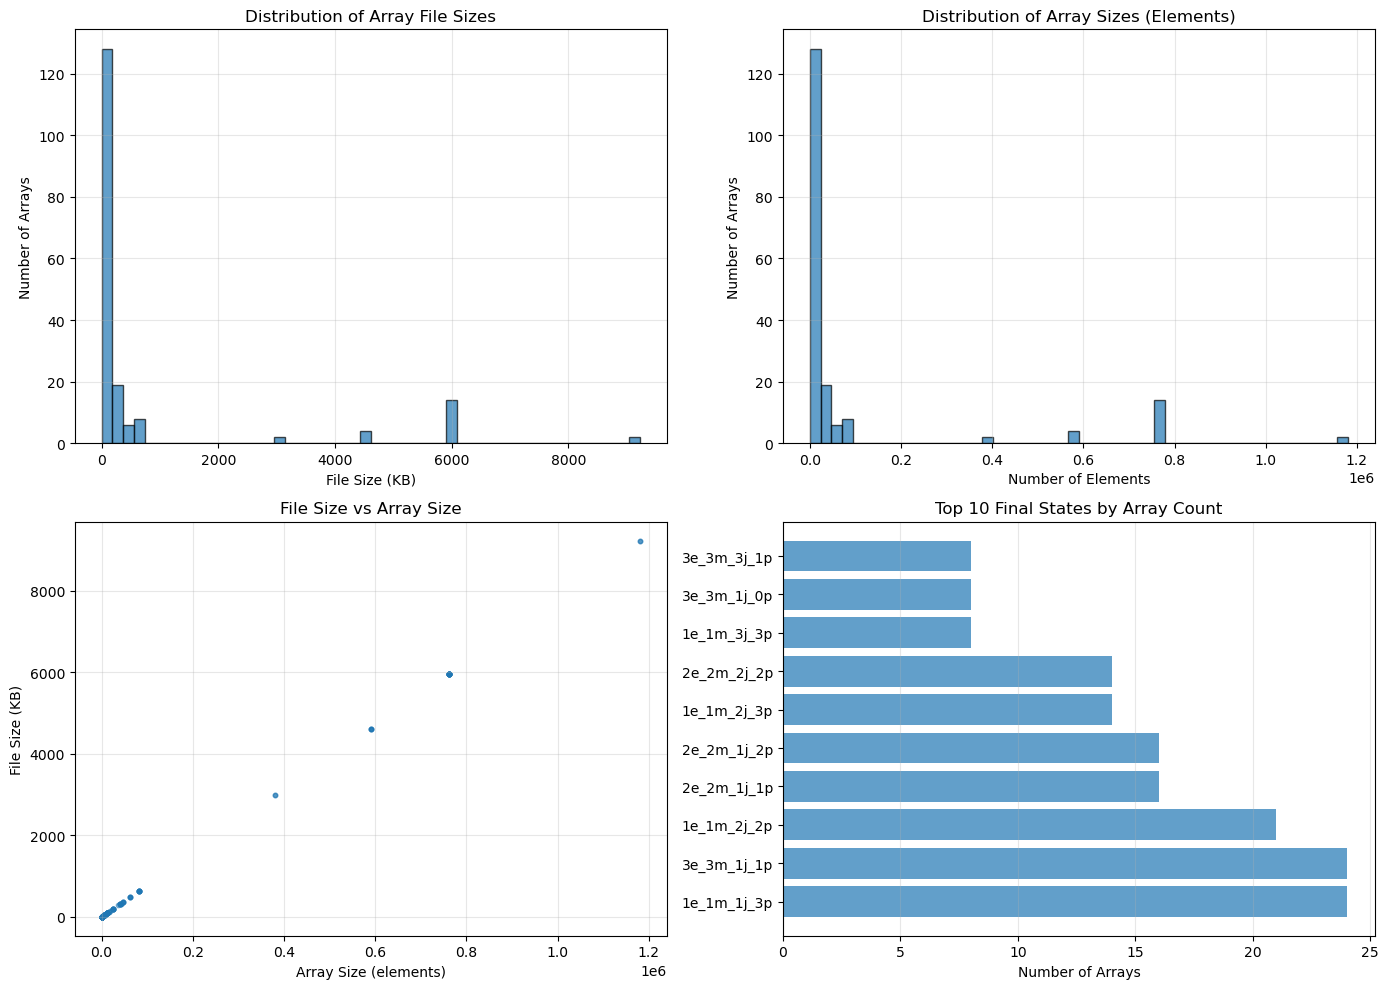

In [10]:
# Visualize file size distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# File size histogram
axes[0, 0].hist(df['file_size'] / 1024, bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('File Size (KB)')
axes[0, 0].set_ylabel('Number of Arrays')
axes[0, 0].set_title('Distribution of Array File Sizes')
axes[0, 0].grid(True, alpha=0.3)

# Array size histogram
axes[0, 1].hist(df['array_size'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Number of Elements')
axes[0, 1].set_ylabel('Number of Arrays')
axes[0, 1].set_title('Distribution of Array Sizes (Elements)')
axes[0, 1].grid(True, alpha=0.3)

# File size vs Array size
axes[1, 0].scatter(df['array_size'], df['file_size'] / 1024, alpha=0.5, s=10)
axes[1, 0].set_xlabel('Array Size (elements)')
axes[1, 0].set_ylabel('File Size (KB)')
axes[1, 0].set_title('File Size vs Array Size')
axes[1, 0].grid(True, alpha=0.3)

# Group by final state - array sizes
if len(df) > 0:
    fs_counts = df.groupby('final_state')['array_size'].agg(['mean', 'std', 'count'])
    top_fs = fs_counts.nlargest(10, 'count')
    
    axes[1, 1].barh(range(len(top_fs)), top_fs['count'], alpha=0.7)
    axes[1, 1].set_yticks(range(len(top_fs)))
    axes[1, 1].set_yticklabels([fs[:30] + '...' if len(fs) > 30 else fs for fs in top_fs.index])
    axes[1, 1].set_xlabel('Number of Arrays')
    axes[1, 1].set_title('Top 10 Final States by Array Count')
    axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


In [11]:
# Summary statistics
print("=== Overall Statistics ===")
print(f"Total arrays analyzed: {len(df)}")
print(f"Unique base files: {df['base_filename'].nunique()}")
print(f"Unique final states: {df['final_state'].nunique()}")
print(f"Unique combinations: {df['combination_str'].nunique()}")

print("\n=== Array Size Statistics ===")
print(df['array_size'].describe())

print("\n=== File Size Statistics ===")
print((df['file_size'] / 1024).describe())

# Find most common patterns
print("\n=== Most Common Patterns ===")
print("\nTop 10 most common array sizes:")
print(df['array_size'].value_counts().head(10))

print("\nTop 10 most common final states:")
print(df['final_state'].value_counts().head(10))


=== Overall Statistics ===
Total arrays analyzed: 183
Unique base files: 3
Unique final states: 18
Unique combinations: 61

=== Array Size Statistics ===
count    1.830000e+02
mean     9.982780e+04
std      2.445709e+05
min      3.600000e+01
25%      4.320000e+02
50%      3.726000e+03
75%      3.859650e+04
max      1.180818e+06
Name: array_size, dtype: float64

=== File Size Statistics ===
count     183.000000
mean      780.029713
std      1910.710252
min         0.406250
25%         3.500000
50%        29.234375
75%       301.660156
max      9225.265625
Name: file_size, dtype: float64

=== Most Common Patterns ===

Top 10 most common array sizes:
array_size
12312     17
762210    14
324       11
432        9
82458      8
54         8
648        8
3726       8
4752       8
41229      6
Name: count, dtype: int64

Top 10 most common final states:
final_state
1e_1m_1j_3p    24
3e_3m_1j_1p    24
1e_1m_2j_2p    21
2e_2m_1j_1p    16
2e_2m_1j_2p    16
1e_1m_2j_3p    14
2e_2m_2j_2p    14
3e_3m

## Conclusions

Based on the analysis above:

1. **Why similar file sizes?**
   - Arrays with the same number of elements have similar file sizes
   - File size = NumPy header (~128 bytes) + data (num_elements × bytes_per_element)
   - Arrays from the same final state often have the same number of events

2. **Why same number of elements?**
   - Different combinations from the same final state can produce the same number of valid events
   - Filtering and slicing operations may result in the same number of events passing for different combinations
   - This is expected behavior when combinations have overlapping particle requirements

3. **Are arrays with same size identical?**
   - **If identical**: ⚠️ Potential bug - different combinations should produce different invariant masses
   - **If different**: ✓ Expected - different combinations represent different physical quantities
   - Always verify that arrays with different combinations are NOT identical
